# Wielowarstwowa sieć jednokierunkowa MLP w Tensorflow, Część I

## Wstęp:

Celem ćwiczenia jest wprowadzenie do biblioteki Tensorflow i  przypomnienie podstawowej sieci MLP i wpływu hiperparametrów na uczenie i jakość otrzymywanych wyników.
Sieć powinna rozwiązywać problem klasyfikacji obrazów ze zbioru  CIFAR-10.  
Należy zdefiniować architekturę modelu, funkcję celu i dostarczyć dane do sieci. (Tensorflow automatycznie oblicza pochodne funkcji celu).


Zadania na laboratorium będą oparte o interfejs Subclassing API. W notebooku znajduje się treść zadania wraz ze zdefiniowanymi klasami bazowymi i narzędziami pomocniczymi.

Paczki, które mogą być dodatkowo zastosowane:  
- numpy  
- scikit-learn (Metryki)  
- matplotlib, seaborn (Wykresy)  
- tqdm (Pasek postępu)


## Lista zadań (Część I): 
1. Wykorzystując klasę bazową zdefiniowaną w BaseLayer zaimplementuj warstwę w pełni połączoną. (Dodawanie zmiennych do warstwy odbywa się za pomocą metody add_weight). Źródło:  https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) (0.5 pkt).

2. Wykorzystując klasę bazową zdefiniowaną w BaseModel i zaimplementowaną warstwę w pełni połączoną w zadaniu 1 zdefiniuj architekturę sieci, funkcję uczenia sieci i funkcję ewaluacji (0.5 pkt).  
    **Przetwarzanie wstępne**
    - Spłaszczenie obrazu z wymiaru 32x32x3 na wymiar 3072
    
   **Architektura modelu do implementacji**
    - Warstwa w pełni połączona z 128 neuronami i funkcją aktywacji ReLU
    - Warstwa w pełni połączona z 10 neuronami i funkcją aktywacji Softmax
    
    Funkcje aktywacji znajdują się w module tensorflow.keras.activation
    
   **Hiperparametry uczenia**
    - Wielkość paczki: 100
    - Optymalizator: Adam
    - Współczynnik uczenia: 0.01
    - Liczba epok: 10
    - Funkcja kosztu: tf.keras.losses.SparseCategoricalCrossentropy
    
 
    
    

3. Przedstaw wykres accuracy, krzywą funkcji kosztu i podaj macierz pomyłek (confusion matrix) (1 pkt)
4. Zwizualizuj kilka przykładów na klasę, dla których model podejmowal złą decyzję i przeanalizuj dlaczego (1 pkt)

Jakość analizy i realizacji (prawidłowość wniosków, klarowność prezentacji, rozumienie modelu, jakość kodu)  (2 pkt)  

### Ograniczenia

1. Zadania 1 i 2 muszą być oddane razem z Zadaniem 3

2. Wykorzystanie gotowych modułów implementujących warstwy sieci np. tensorflow.keras.layers i innych jest zabronione!


## TensorFlow

### Wcztywanie zbioru danych i mechanizm paczkowania danych

Zbiór CIFAR10 jest jednym ze zbiorów danych, dla których zdefiniowano interfejs do jego wczytywania w module `tensorflow.keras.datasets`. 

Wczytanie zbiorów wygląda następująco
```python
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
```

Normalizacja wartości piskeli 0-255 do 1

```python
x_train = x_train / 255.0
x_test = x_test / 255.0
```

### Paczkowanie danych 
Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`

Przykładowy kod:
```python
# Utworzenie obiektu
train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle i zdefiniowanie rozmiaru paczki
# buffer_size - rozmiar bufora do przeprowadzenia operacji shuffle (Ważne!); 
# batch_size - rozmiar paczki;
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=100)

# Iterowanie po paczkach:
for x, y in train_dataset:
    Some code...
```

**Rozmiar bufora (buffer_size) wpływa na losowość całej operacji shuffle!**   
Szczegóły można znaleźć tutaj: [LINK](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)



## Klasy bazowe

In [1]:
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass



# Rozwiązanie

In [3]:
class BaseLayer(AbstractLayer):
    def __init__(self, num_outputs, input_shape, activation=tf.keras.activations.relu):
        super(BaseLayer, self).__init__()
        self.num_outputs = num_outputs
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]),
                                      self.num_outputs], initializer='random_normal')
        self.bias = self.add_weight("bias", shape=[self.num_outputs], initializer='random_normal')
        self.activation = activation

    def call(self, input):
        x = tf.matmul(input, self.kernel) + self.bias
        return self.activation(x)
    

class BaseModel(AbstractModel):
    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.layer_1 = BaseLayer(num_outputs=128, input_shape=[3072], activation=tf.keras.activations.relu)
        self.layer_2 = BaseLayer(num_outputs=10, input_shape=[128], activation=tf.keras.activations.softmax)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        return x

    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        self.epoch_loss = []
        self.epoch_accuracy = []
        
        x_train = kwargs.get('x', None)
        y_train = kwargs.get('y', None)
        epochs = kwargs.get('epochs', 10)
        batch_size = kwargs.get('batch_size', 100)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        learning_coef = kwargs.get('learning_coef', 0.01)
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam(learning_rate=learning_coef))
        
        train_dataset = self._extract_train_dataset(x_train, y_train)

        for epoch in range(epochs):
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

            for x, y in train_dataset:
                x = tf.dtypes.cast(x, tf.float32)
                y = tf.dtypes.cast(y, tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)
                
            self.epoch_accuracy.append(epoch_acc.result().numpy())

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))

    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        x = self._preprocess_x(x)
        logits = model(x)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        return prediction
    
    def _extract_train_dataset(self, x_train, y_train):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=batch_size)
        return train_dataset
    
    def _preprocess_x(self, x_set):
        x_set = x_set / 255.0
        x_set = [x.flatten() for x in x_set]
        return x_set

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 77s 0us/step


In [ ]:
%%time

batch_size = 100
learning_coef = 0.001  # 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model = BaseModel()

model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
         epochs=epochs, cost_func=cost_func, optimizer=optimizer)

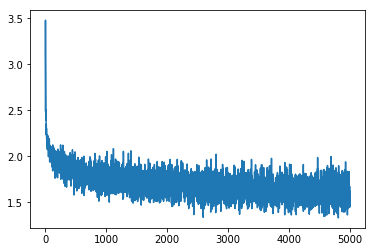

In [7]:
plt.plot(model.epoch_loss)

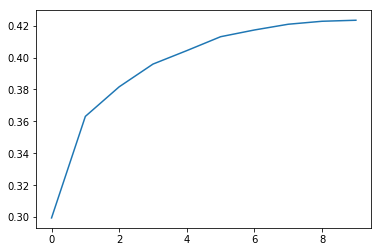

In [8]:
plt.plot(model.epoch_accuracy)

[Text(0.5, 0, 'airplane'),
 Text(1.5, 0, 'automobile'),
 Text(2.5, 0, 'bird'),
 Text(3.5, 0, 'cat'),
 Text(4.5, 0, 'deer'),
 Text(5.5, 0, 'dog'),
 Text(6.5, 0, 'frog'),
 Text(7.5, 0, 'horse'),
 Text(8.5, 0, 'ship'),
 Text(9.5, 0, 'truck')]

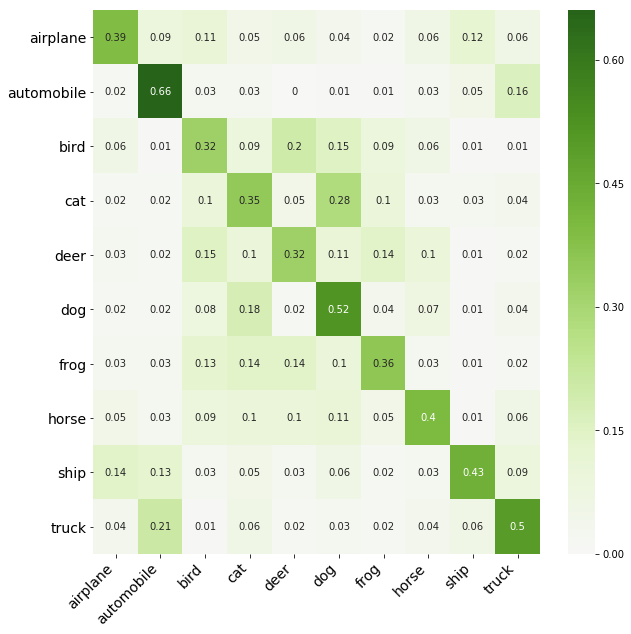

In [16]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_dataset = (x_test, y_test)
y_pred = model.predict(x_test)
conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

fig, ax = plt.subplots(figsize=(10,10))   
ax = sns.heatmap(conf_matrix, cmap="PiYG",
            annot=True, center=0)
ax.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, ha='right', fontsize=14)
ax.xaxis.set_ticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=14)

In [17]:
images = []
labels_pred = []
labels_real = []
classes = {}
for i in range(10):
    classes[i] = 0

for image, pred, real in zip(x_test, y_pred, y_test):
    if pred != real and classes[real.item()] < 3:
        images.append(image)
        labels_pred.append(pred)
        labels_real.append(real.item())
        classes[real.item()] += 1

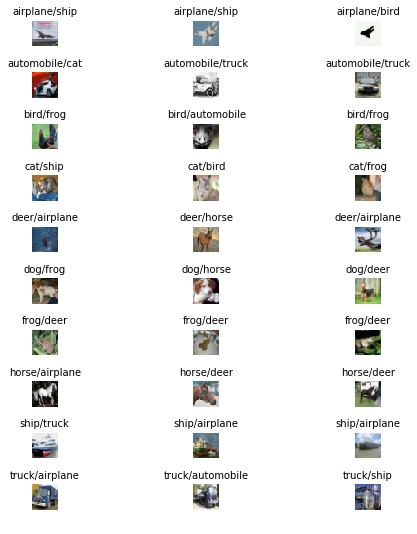

In [18]:
def show_batch(images, labels_pred, labels_real):
    labels_real, labels_pred, images = zip(*sorted(zip(labels_real, labels_pred, images), key=lambda tup: tup[0]))
    fig = plt.figure(figsize=(7,9))
    fig.subplots_adjust(wspace=1.4, hspace=1)
    for n in range(30):
        ax = plt.subplot(10, 3, n+1)
        plt.imshow(images[n])
        title = str(CLASS_NAMES[labels_real[n]]) + '/' + str(CLASS_NAMES[labels_pred[n]])
        plt.title(title, fontsize = 10)
        plt.axis('off')
        
show_batch(images, labels_pred, labels_real)